In [1]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

In [2]:
from scipy.optimize import curve_fit
from scipy.stats import expon
from functools import partial
from scipy.integrate import quad

In [3]:
%matplotlib inline

# Resource modeling in CHIME - Part 2 of n
## A prototype stochastic census submodel

In [Part 1](https://github.com/misken/c19/blob/master/mychime/modeling/chime_flow_resources_p1.ipynb) of this CHIME resource modeling series, the goal was to:

> try to help people (including myself) better understand the concepts, math and code behind the resource modeling in [CHIME](https://github.com/CodeForPhilly/chime).

In this notebook I want to explore possibilities for using queueing model based approximations for the census projections in CHIME. My primary reasons are:

* current census model is a deterministic, discrete time, "fluid flow" type model and I wonder about the impact of ignoring stochastic effects in length of stay and in number of admits per day.
* a stochastic model offers the possibility of presenting projected census distribution information for each day instead of one fixed point forecast. It's the tails that can get you.
* I've spent a good part of my career building stochastic models, both queueing based and discrete event simulations, for healthcare systems and I've seen the value they can bring.

This approach is different, but I'd say complementary, to efforts to directly model input parameter uncertainty in some sort of Bayesian framework. In this approach, we are treating the projected admits as an estimate of the underlying arrival rate function in a time-dependent stochastic process. Specifically, we are modeling arrivals with a [non-homogeneous Poisson process](https://en.wikipedia.org/wiki/Poisson_point_process) (NHPP), a widely accepted approach to modeling time-dependent arrivals to queueing systems subject to, essentially, random arrivals. Then we model the system of hospital arrivals and subsequent stay in the hospital as a $M_t/G/\inf$ queueing system (i.e. Markovian arrivals, general service time distribution, infinite number of servers). There's a a handy result that census in such a system is Poisson distributed at each time point, $t$, with mean value function, $m(t)$, where $m(t)$ is a relatively simple function (an integral) of the arrival rate function $\lambda(t)$ and the stationary excess (residual) distribution of the service time (length of stay in our case) random variable. By obtaining $m(t)$, it is easy then to compute percentiles of census using the Poisson distribution directly (for smallish census values) or the normal approximation to the Poisson (with a continuity correction) for moderate to large census values.

All the key details of $M_t/G/\inf$ systems can be found in the following two references and sources within:

* [Eick, 1993] Eick, Stephen G., William A. Massey, and Ward Whitt. "The physics of the Mt/G/∞ queue." Operations Research 41, no. 4 (1993): 731-742.
* [Eick, 1993b] Eick, Stephen G., William A. Massey, and Ward Whitt. "Mt/G/∞ queues with sinusoidal arrival rates." Management Science 39, no. 2 (1993): 241-252.

**Note:** This notebook was created on 2020-04-14 based on CHIME code as of that date.

## Simulate a base scenario

I'll use parameters consistent with v1.1.3 of CHIME and run the model using the `sim_chime_scenario_runner` wrapper I developed which calls the CHIME model. In addition providing the standard CHIME output dataframes, the `runner` wrapper returns long and wide formatted dataframes which consolidate admit and census columns and can optionally include actual admit and census values by date from our system. These long and wide form dataframes make the plotting and modeling I do here a little easier.

Here are a set of [CHIME input values](https://code-for-philly.gitbook.io/chime/what-is-chime/parameters) for the current model.

%load data/semi_0408b.cfg

    --population 5026226
    --market-share 0.32
    --current-hospitalized 1059
    --date-first-hospitalized 2020-02-20
    --mitigation-date 2020-03-21
    --current-date 2020-04-08
    --relative-contact-rate 0.55
    --hospitalized-rate 0.025
    --icu-rate 0.0075
    --ventilated-rate 0.005
    --infectious-days 10
    --hospitalized-day 7
    --icu-days 9
    --ventilated-day 10
    --n-days 120
    --recovered 0






Let's run the CHIME model for this scenario.

In [4]:
# Import the scenario runner. It will import various penn_chime artifacts.
import sim_chime_scenario_runner as runner

In [11]:
# This scenario name string will get prepended to all output files
scenario = 'semi_0408'
config_file = 'data/semi_0408.cfg'
actual_file = 'data/semi_actual_0408.csv'

# Create a penn_chime Parameters object
p = runner.create_params_from_file(config_file) 

# Run the model
model, results = runner.sim_chime(scenario, p) 

# Add the actual values
results = runner.include_actual(results, actual_file)

2020-04-15 08:21:36,210 - penn_chime.model.parameters - INFO - Using file: data/semi_0408.cfg
2020-04-15 08:21:36,211 - penn_chime.model.sir - INFO - Using date_first_hospitalized: 2020-02-20; current_date: 2020-04-08; i_day: 48, current_hospitalized: 1059
2020-04-15 08:21:36,253 - penn_chime.model.sir - INFO - Estimated doubling_time: 3.26780508121616
2020-04-15 08:21:36,257 - penn_chime.model.sir - INFO - len(np.arange(-i_day, n_days+1)): 169
2020-04-15 08:21:36,258 - penn_chime.model.sir - INFO - len(raw_df): 169


As a reminder, here are the keys in the `results` dictionary. My `sim_chime_scenario_runner.sim_chime()` function just:

- packages up the various dataframes that CHIME creates, 
- adds wide and long versions to facilitate plotting and other analysis,
- adds a few dictionaries of variable values into a container dictionary for output processing convenience.

In [12]:
results.keys()

dict_keys(['result_type', 'scenario', 'input_params_dict', 'important_variables_dict', 'sim_sir_w_date_df', 'dispositions_df', 'admits_df', 'census_df', 'adm_cen_wide_df', 'adm_cen_long_df'])

This notebook will mostly be using `adm_cen_wide_df`, `adm_cen_long_df` and the `input_params_dict`. So, let's pull them out into variables to save some typing.

In [13]:
adm_cen_wide_df = results['adm_cen_wide_df']
adm_cen_long_df = results['adm_cen_long_df']
inputs = results['input_params_dict']

Let's take a look at each.

In [15]:
adm_cen_wide_df.head(10)

,day,date,admits_hospitalized,admits_icu,admits_ventilated,census_hospitalized,census_icu,census_ventilated,scenario,covid_census,covid_admits
0,-48,2020-02-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,semi_0408,1.0,1.0
1,-47,2020-02-21,0.336289,0.100887,0.067258,0.336289,0.100887,0.067258,semi_0408,0.0,0.0
2,-46,2020-02-22,0.415747,0.124724,0.083149,0.752035,0.225611,0.150407,semi_0408,0.0,0.0
3,-45,2020-02-23,0.513976,0.154193,0.102795,1.266012,0.379804,0.253202,semi_0408,0.0,0.0
4,-44,2020-02-24,0.635412,0.190624,0.127082,1.901424,0.570427,0.380285,semi_0408,2.0,1.0
5,-43,2020-02-25,0.785533,0.235660,0.157107,2.686957,0.806087,0.537391,semi_0408,3.0,1.0
6,-42,2020-02-26,0.971115,0.291334,0.194223,3.658072,1.097422,0.731614,semi_0408,0.0,0.0
7,-41,2020-02-27,1.200528,0.360158,0.240106,4.858599,1.457580,0.971720,semi_0408,4.0,1.0
8,-40,2020-02-28,1.484118,0.445235,0.296824,6.006428,1.902815,1.268543,semi_0408,0.0,0.0
9,-39,2020-02-29,1.834670,0.550401,0.366934,7.425352,2.453216,1.635477,semi_0408,0.0,0.0


In [16]:
adm_cen_long_df.head(10)

,scenario,day,date,dispo_measure,cases
0,semi_0408,-48,2020-02-20,admits_hospitalized,0.000000
1,semi_0408,-47,2020-02-21,admits_hospitalized,0.336289
2,semi_0408,-46,2020-02-22,admits_hospitalized,0.415747
3,semi_0408,-45,2020-02-23,admits_hospitalized,0.513976
4,semi_0408,-44,2020-02-24,admits_hospitalized,0.635412
5,semi_0408,-43,2020-02-25,admits_hospitalized,0.785533
6,semi_0408,-42,2020-02-26,admits_hospitalized,0.971115
7,semi_0408,-41,2020-02-27,admits_hospitalized,1.200528
8,semi_0408,-40,2020-02-28,admits_hospitalized,1.484118
9,semi_0408,-39,2020-02-29,admits_hospitalized,1.834670


In [17]:
inputs

{'current_date': datetime.date(2020, 4, 8),
 'current_hospitalized': 1059,
 'date_first_hospitalized': datetime.date(2020, 2, 20),
 'doubling_time': 3.26780508121616,
 'hospitalized': Disposition(days=7, rate=0.025),
 'icu': Disposition(days=9, rate=0.0075),
 'infectious_days': 10,
 'market_share': 0.32,
 'max_y_axis': None,
 'mitigation_date': datetime.date(2020, 3, 21),
 'n_days': 120,
 'population': 5026226,
 'region': None,
 'relative_contact_rate': 0.55,
 'recovered': 0,
 'ventilated': Disposition(days=10, rate=0.005),
 'labels': {'hospitalized': 'Hospitalized',
  'icu': 'ICU',
  'ventilated': 'Ventilated',
  'day': 'Day',
  'date': 'Date',
  'susceptible': 'Susceptible',
  'infected': 'Infected',
  'recovered': 'Recovered'},
 'dispositions': {'hospitalized': Disposition(days=7, rate=0.025),
  'icu': Disposition(days=9, rate=0.0075),
  'ventilated': Disposition(days=10, rate=0.005)}}

## Temporal relationship between admits and census

It's well known in infinite capacity queueing models with time-dependent Poisson arrivals that census lags behind arrivals (admits). Makes sense. Let's see this. First a little data wrangling to just focus on hospital related measures for this notebook (same ideas will apply to icu and vent).


In [18]:
adm_cen_wide_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 0 to 168
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   day                  169 non-null    int64         
 1   date                 169 non-null    datetime64[ns]
 2   admits_hospitalized  169 non-null    float64       
 3   admits_icu           169 non-null    float64       
 4   admits_ventilated    169 non-null    float64       
 5   census_hospitalized  169 non-null    float64       
 6   census_icu           169 non-null    float64       
 7   census_ventilated    169 non-null    float64       
 8   scenario             169 non-null    object        
 9   covid_census         49 non-null     float64       
 10  covid_admits         49 non-null     float64       
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 15.8+ KB


Add a column for day starting at 0.

In [19]:
adm_cen_long_df['day0'] = adm_cen_long_df['day'] - int(adm_cen_long_df['day'].min())
adm_cen_wide_df['day0'] = adm_cen_wide_df['day'] - int(adm_cen_wide_df['day'].min())

In [20]:
adm_cen_long_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1352 entries, 0 to 1351
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   scenario       1352 non-null   object        
 1   day            1352 non-null   int64         
 2   date           1352 non-null   datetime64[ns]
 3   dispo_measure  1352 non-null   object        
 4   cases          1112 non-null   float64       
 5   day0           1352 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 63.5+ KB


In [21]:
adm_cen_long_df['dispo_measure'].unique()

array(['admits_hospitalized', 'admits_icu', 'admits_ventilated',
       'census_hospitalized', 'census_icu', 'census_ventilated',
       'covid_census', 'covid_admits'], dtype=object)

In [22]:
hosp_measures = ['admits_hospitalized', 'census_hospitalized',
                'covid_census', 'covid_admits']

In [23]:
['scenario', 'day', 'date'] + hosp_measures


['scenario',
 'day',
 'date',
 'admits_hospitalized',
 'census_hospitalized',
 'covid_census',
 'covid_admits']

In [24]:
hosp_measures

['admits_hospitalized', 'census_hospitalized', 'covid_census', 'covid_admits']

In [25]:
hosp_data_long = adm_cen_long_df[adm_cen_long_df.dispo_measure.isin(hosp_measures)]

hosp_data_wide = adm_cen_wide_df.loc[:, ['scenario', 'day', 'day0', 'date'] + hosp_measures]

In [27]:
hosp_data_wide.head()

,scenario,day,day0,date,admits_hospitalized,census_hospitalized,covid_census,covid_admits
0,semi_0408,-48,0,2020-02-20,0.000000,0.000000,1.0,1.0
1,semi_0408,-47,1,2020-02-21,0.336289,0.336289,0.0,0.0
2,semi_0408,-46,2,2020-02-22,0.415747,0.752035,0.0,0.0
3,semi_0408,-45,3,2020-02-23,0.513976,1.266012,0.0,0.0
4,semi_0408,-44,4,2020-02-24,0.635412,1.901424,2.0,1.0


In [28]:
sns.set(rc={'figure.figsize':(9.0, 6.0)})

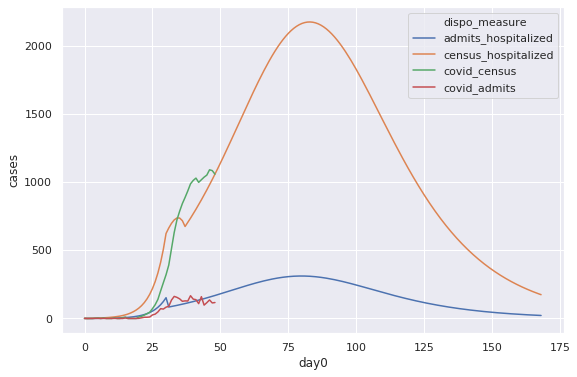

In [29]:
sns.lineplot(x='day0', y='cases', hue='dispo_measure', 
             data=hosp_data_long);

Let's look more closely at how the peaks relate.

In [30]:
x = np.array(hosp_data_wide.day0)
y_admits = np.array(hosp_data_wide.admits_hospitalized)
y_census = np.array(hosp_data_wide.census_hospitalized)
admit_peak = np.argmax(y_admits) + np.min(x)
census_peak = np.argmax(y_census) + np.min(x)
lag_txt = "Census lag = {} days".format(census_peak - admit_peak)

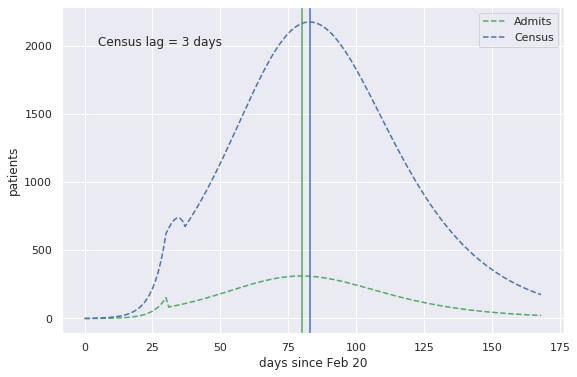

In [31]:
plt.plot(x, y_admits, 'g--', label="Admits")
plt.plot(x, y_census, 'b--', label="Census")
plt.xlabel('days since Feb 20')
plt.ylabel('patients')
plt.axvline(admit_peak, color = 'g')
plt.axvline(census_peak, color = 'b')
plt.text(5,2000, lag_txt)
plt.legend()
plt.show()

Zoom.

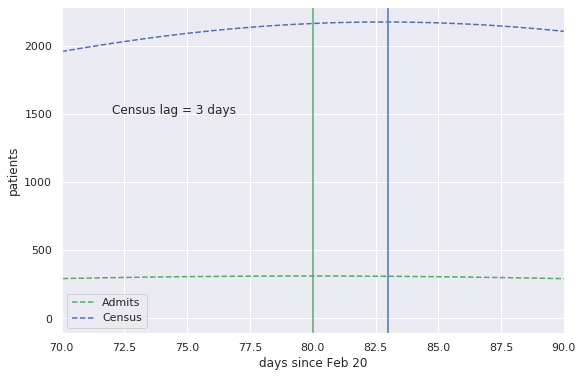

In [32]:
plt.plot(x, y_admits, 'g--', label="Admits")
plt.plot(x, y_census, 'b--', label="Census")
plt.xlabel('days since Feb 20')
plt.ylabel('patients')
plt.xlim(70, 90)
plt.axvline(admit_peak, color = 'g')
plt.axvline(census_peak, color = 'b')
plt.text(72, 1500, lag_txt)
plt.legend()
plt.show()

## Plan of attack for stochastic census model
For $M_t/G/\inf$ queueing models, there are really nice computational formulas for computing the mean value function, $m(t)$, which gives the mean of the Poisson distribution of occupancy at each time $t$. 

See 

* Eick, Stephen G., William A. Massey, and Ward Whitt. "The physics of the Mt/G/∞ queue." Operations Research 41, no. 4 (1993): 731-742.
* Jennings, Otis B., Avishai Mandelbaum, William A. Massey, and Ward Whitt. "Server staffing to meet time-varying demand." Management Science 42, no. 10 (1996): 1383-1394.

In order to use these results, we need do a few things:

* fit some sort of arrival rate function $\lambda(t)$ to the projected admit time series
* decide on length of stay distribution to use for $G$.
* do the above two things wisely so that the math and computing isn't too terrible but is sufficiently accurate in matching mean census.

### Arrival rate plan

From looking at the admit plots above and knowing what we know about SIR models, I'm going to try to fit two logistic functions, one for the growth phase and one for the decay phase. We'll see how they fit together and, if needed, shim them with a quadratic or cubic polynomial. These should be not too bad to work with in the queueing model.

### Service time (LOS) distribution plan

I'll start like all queueing analyses do, assume exponential service time distributions 🙂. Ideally, I'll have some real LOS data soon and can fit some sort of reasonable distribution to the, likely right-skewed, empirical distribution. My other thought is to use a hyperexponential distribution with three parallel stages representing three different patient types - patients with no ICU stay, patients who stay in ICU but no vent, and vent patients. 

## Fit logistic functions to admits
Piece two logistic together - one that's growth and one that's decay. Then we'll shim them if needed. Start by just exploring a logistic growth model for the first part of the projected admit data.

In [33]:
# Function to fit
# def logistic_func_1(x, a, b, c):
#      return a /(1 + b * c ** -x)

# Alternative parameterization - more fitting for epi modeling
def logistic_func(t, L, k, t0):
     return L /(1 + np.exp(-(k*(t - t0))))

Let's just throw some reasonable values in and plot.

In [35]:
(L, k, t0) = (320.0, 0.05, 45.0)

In [36]:
t = np.array(hosp_data_wide.day0)
y = np.array(logistic_func(t, L, k, t0))

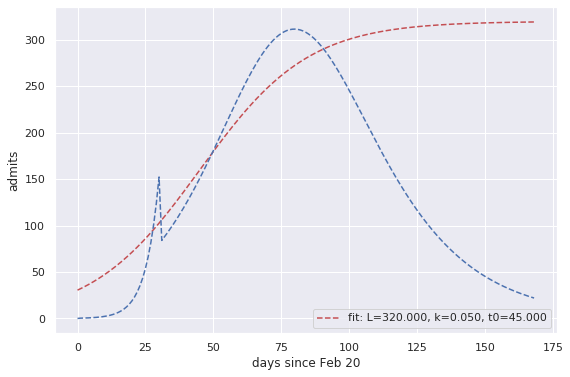

In [37]:

plt.plot(t, y, 'r--',
         label='fit: L={:5.3f}, k={:5.3f}, t0={:5.3f}'.format(L, k, t0))
plt.plot(t, y_admits, 'b--')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.show()

Ok, let's try to find a good fit from time 0 up until the peak and then fit a second logistic model for the peak and beyond.

In [38]:
# Find peaks and separate arrays into two pieces
x_peak = np.argmax(y_admits) + np.min(x)
admits_peak = np.max(y_admits) + np.min(x)
x_growth = x[:x_peak + 1]
x_decay = x[x_peak + 1:]
y_act_growth = y_admits[:x_peak + 1]
y_act_decay = y_admits[x_peak + 1:]

# Initial guesses for parameter values
(L0_growth, k0_growth, t00_growth) = (320.0, 0.08, 45.0)
(L0_decay, k0_decay, t00_decay) = (320, -0.08, 115)

Fit a logistic growth model.

In [39]:
popt_growth, pcov_growth = curve_fit(logistic_func, x_growth, y_act_growth,  p0=(L0_growth, k0_growth, t00_growth))
print(popt_growth)
y_fit_growth = logistic_func(x_growth, *popt_growth)

[3.38904351e+02 7.71987832e-02 4.72524131e+01]


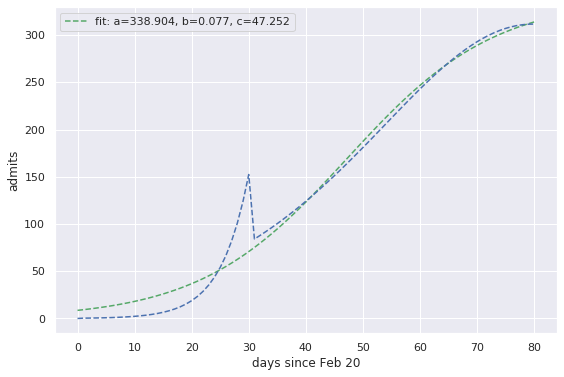

In [41]:
plt.plot(x_growth, y_fit_growth, 'g--',
         label='fit: a={:5.3f}, b={:5.3f}, c={:5.3f}'.format(*popt_growth))
plt.plot(x_growth, y_act_growth, 'b--')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.show()

Now fit the decay side in a similar way.

In [42]:
popt_decay, pcov_decay = curve_fit(logistic_func, x_decay, y_act_decay,  p0=(L0_decay, k0_decay, t00_decay))
print(popt_decay)
y_fit_decay = logistic_func(x_decay, *popt_decay)

[ 4.10764931e+02 -4.99844178e-02  1.07160965e+02]


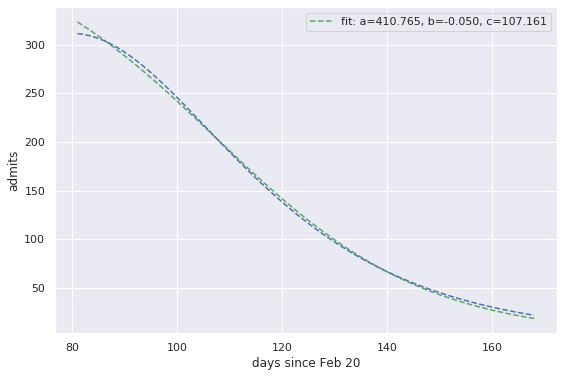

In [43]:
plt.plot(x_decay, y_fit_decay, 'g--',
         label='fit: a={:5.3f}, b={:5.3f}, c={:5.3f}'.format(*popt_decay))
plt.plot(x_decay, y_act_decay, 'b--')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.show()

Let's join the two pieces together and check the overall fit, especially near the peak where the two logistic functions are duct taped together.

In [44]:
# Join the pieces
y_fit = np.concatenate((y_fit_growth, y_fit_decay), axis=None)
x_fit_peak = np.argmax(y_fit)
admits_fit_peak = np.max(y_fit)

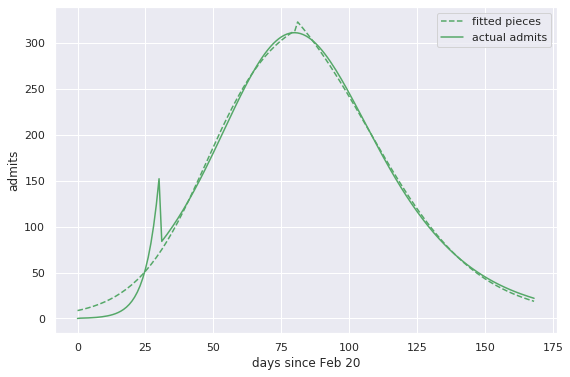

In [45]:
plt.plot(x, y_fit, 'g--',
         label='fitted pieces')
plt.plot(x, y_admits, 'g',
         label='actual admits')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.show()

Zoom in on the peak.

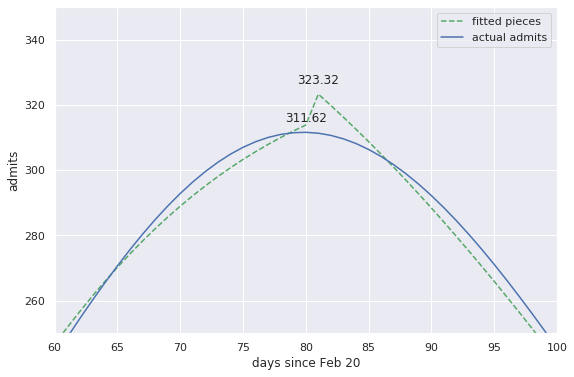

In [46]:
plt.plot(x, y_fit, 'g--',
         label='fitted pieces')
plt.plot(x, y_admits, 'b',
         label='actual admits')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.xlim(60, 100)
plt.ylim(250, 350)
label_fitted = "{:.2f}".format(admits_fit_peak)
label_admits = "{:.2f}".format(admits_peak)
plt.annotate(label_fitted, # this is the text
                 (x_fit_peak, admits_fit_peak), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.annotate(label_admits, # this is the text
                 (x_peak, admits_peak), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.legend()
plt.show()

Maybe we can improve this by perhaps using a spline to match the hump between, say, x=78 and x=87. 

In [47]:
shimx_lower = 78
shimx_upper = 87
x_shim = x[shimx_lower:shimx_upper + 1]
y_shim = y_admits[shimx_lower:shimx_upper + 1]

I'm going to try a quadratic as it looks sufficient to match the hump.

In [48]:
quad_shim = np.polyfit(x_shim, y_shim, 2)

In [49]:
quad_shim

array([-1.90608093e-01,  3.04115453e+01, -9.01435050e+02])

In [50]:
# Function to fit
def quad_func(x, a, b, c):
     return a * x **2 + b * x + c

In [51]:
y_fit_shim = quad_func(x_shim, *quad_shim)
y_fit_shim

array([311.00584787, 311.49192259, 311.59678113, 311.32042349,
       310.66284965, 309.62405963, 308.20405343, 306.40283104,
       304.22039246, 301.6567377 ])

In [52]:
y_fit_w_shim = np.concatenate((y_fit_growth[:shimx_lower], y_fit_shim, y_fit_decay[shimx_upper - x_peak:]), axis=None)

In [53]:
# Check for shape consistency (e.g. no off by one errors)
assert y_fit_w_shim.shape == x.shape

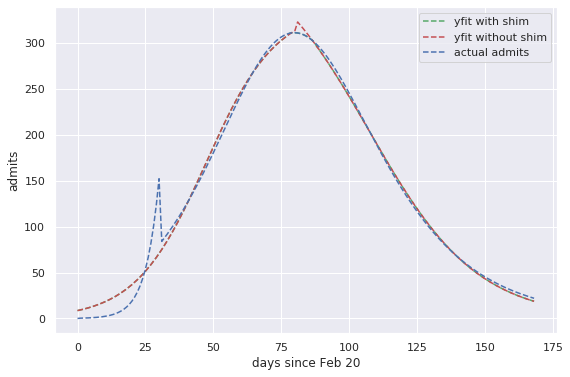

In [54]:
plt.plot(x, y_fit_w_shim, 'g--', label='yfit with shim')
plt.plot(x, y_fit, 'r--', label='yfit without shim')
plt.plot(x, y_admits, 'b--', label='actual admits')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.show()

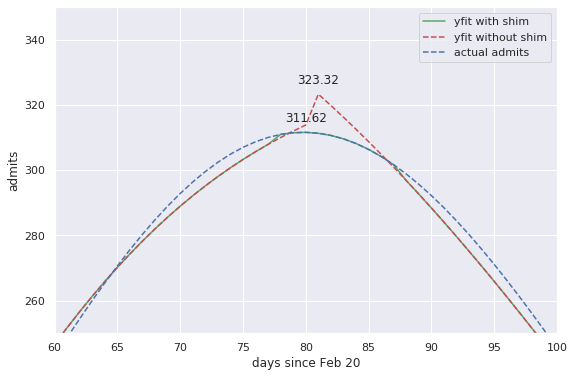

In [55]:
plt.plot(x, y_fit_w_shim, 'g-', label='yfit with shim')
plt.plot(x, y_fit, 'r--', label='yfit without shim')
plt.plot(x, y_admits, 'b--', label='actual admits')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.xlim(60, 100)
plt.ylim(250, 350)
label_fitted = "{:.2f}".format(admits_fit_peak)
label_admits = "{:.2f}".format(admits_peak)
plt.annotate(label_fitted, # this is the text
                 (x_fit_peak, admits_fit_peak), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.annotate(label_admits, # this is the text
                 (x_peak, admits_peak), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.legend()
plt.show()

Nice.

Let's create a function to represent this three-piece arrival rate function. Arrival rate related parameters always use the Greek letter $\lambda$ (see any queueing text) and I must do the same even though this has nothing to do with a Python *lambda function*.

In [56]:
def admit_lambda(t, t1=0, t2=0, L0_g=0, k0_g=0, t0_g=0,
                L0_d=0, k0_d=0, t0_d=0,
                a=0, b=0, c=0):
    
    if t<=0:
        return 0
    elif 0 < t <= t1:
        return logistic_func(t, L0_g, k0_g, t0_g)
    elif t1 < t <= t2:
        return quad_func(t, a, b, c)
    else:
        return logistic_func(t, L0_d, k0_d, t0_d)
        

In [57]:
print(popt_growth)
print(popt_decay)
print(quad_shim)

[3.38904351e+02 7.71987832e-02 4.72524131e+01]
[ 4.10764931e+02 -4.99844178e-02  1.07160965e+02]
[-1.90608093e-01  3.04115453e+01 -9.01435050e+02]


In [58]:
admit_lambda(180,shimx_lower, shimx_upper, *popt_growth, *popt_decay, *quad_shim)

10.499331192620735

In [59]:
a, b, c = quad_shim

In [60]:
print(a, b, c)

-0.1906080930692023 30.41154533732478 -901.4350502112261


## Service time distribution parameters

First let's compute implied ALOS values for subpopulations of the model:

* patients who do not use an ICU bed
* ICU patients who do not use a vent

This is more just for information feedback to make sure ALOS inputs we are using are reasonable.

In [61]:
vars(p)

{'current_date': datetime.date(2020, 4, 8),
 'current_hospitalized': 1059,
 'date_first_hospitalized': datetime.date(2020, 2, 20),
 'doubling_time': 3.26780508121616,
 'hospitalized': Disposition(days=7, rate=0.025),
 'icu': Disposition(days=9, rate=0.0075),
 'infectious_days': 10,
 'market_share': 0.32,
 'max_y_axis': None,
 'mitigation_date': datetime.date(2020, 3, 21),
 'n_days': 120,
 'population': 5026226,
 'region': None,
 'relative_contact_rate': 0.55,
 'recovered': 0,
 'ventilated': Disposition(days=10, rate=0.005),
 'labels': {'hospitalized': 'Hospitalized',
  'icu': 'ICU',
  'ventilated': 'Ventilated',
  'day': 'Day',
  'date': 'Date',
  'susceptible': 'Susceptible',
  'infected': 'Infected',
  'recovered': 'Recovered'},
 'dispositions': {'hospitalized': Disposition(days=7, rate=0.025),
  'icu': Disposition(days=9, rate=0.0075),
  'ventilated': Disposition(days=10, rate=0.005)}}

In [62]:
hosp_los = p.hospitalized.days
hosp_pct = p.hospitalized.rate
icu_los = p.icu.days
vent_los = p.ventilated.days
icu_pct = p.icu.rate
vent_pct = p.ventilated.rate

## Implied ALOS values

Let's start by computing implied ALOS for non-vent ICU, $C^{*}$ and non-ICU hospital, $H^{*}$

In [63]:
pct_icu_w_vent = vent_pct / icu_pct
print("Proportion of icu patients requiring vent: {0:.3f}".format(pct_icu_w_vent))
icu_los_star = (icu_los - pct_icu_w_vent * vent_los) / (1.0 - pct_icu_w_vent)
print("ALOS for icu patients NOT requiring vent: {0:.1f}".format(icu_los_star))

Proportion of icu patients requiring vent: 0.667
ALOS for icu patients NOT requiring vent: 7.0


In [64]:
pct_hosp_w_icu = icu_pct / hosp_pct
print("Proportion of hospitalized patients requiring ICU: {0:.3f}".format(pct_hosp_w_icu))
hosp_los_star = (hosp_los - pct_hosp_w_icu * icu_los) / (1.0 - pct_hosp_w_icu)
print("ALOS for hospitalized patients NOT requiring ICU: {0:.1f}".format(hosp_los_star))

Proportion of hospitalized patients requiring ICU: 0.300
ALOS for hospitalized patients NOT requiring ICU: 6.1


## Simple one patient type models

Let's start with independent models for hospital beds, ICU beds, and vents. Just doing hospital beds in this notebook. 
### Exponential service times

If $S$ is our service time random variable with cdf $G(t) = P(S \leq t)$, then for exponentially distributed $S$, we have

$$
G(t) = P(S \leq t) = 1 - e^{-\mu t}
$$

where $\mu$ is the service rate. In our context, $\mu$ is the reciprocal of ALOS. We'll denote the ALOS for hospital patients by $\bar{S}$, and note that $E[S] = \bar{S}$.

For $M_t/G/\inf$ systems, an important role in computing $m(t)$ is played by the *stationary excess distribution*, $S_e$, of the service time random variable, $S$. This is also called the *residual life*. Denote the cdf of $S_e$ by $G_e$. Then (this is Equation 1 in the [Eick, 1993b]),

$$
G_e(t) = P(S_e \leq t) = \frac{1}{E[S]} \int_{0}^{t} G^{c}(u)du, t \geq 0,
$$

where $G^{c}(t) = 1 - G(t)$.

The key result, which dates back to the mid-20th century, is that the census in this system at each time point, $t$, is Poisson distributed with mean

$$
m(t) = \int_{0}^{\inf} G^{c}(u)\lambda(t-u)du
$$

Another representation for the RHS above shows the intuitive result that the expected census is an accumulation of arrivals over a random service time before time $t$. In CHIME, this is analogous to the `cumsum` of admits over a fixed length of stay value (i.e. the user input for hospital length of stay). Of course, in CHIME, the service time is treated as a deterministic (non-random) variable.

$$
m(t) = E\left[\int_{t-S}^{t} \lambda(u)du\right] = E[\lambda(t-S_e)]E[S]
$$

Of course, due to the memoryless property of the exponential distribution, the stationary excess distribution in a $M_t/M/\inf$ system is just the same exponential distribution. When we model length of stay with other, non-exponential distributions, this will not be the case. 



## Estimation of $m(t)$ for exponential length of stay distribution
Need to derive $m(t)$ for our piecewise logistic (with a quadratic shim) arrival rate model. For exponential distributed length of stay, 

$$
m(t) = \int_{0}^{\infty} G^{c}(u)\lambda(t-u)du
$$

becomes

$$
m(t) = \int_{0}^{t} e^{\mu s}\lambda(t-s)ds
$$

This should an easy integral to numerically integrate. Note that the `scipy.stats` function `sf`, or *survival function* is just the complement of the `cdf`, and is the $e^{\mu s}$ term in the integral we need to evaluate.

Create an exponential random variable using `scipy.stats`.

In [70]:
rv_hosp = expon(scale = hosp_los)

In [71]:
rv_hosp.expect()

7.000000000000001

In [72]:
print(rv_hosp.cdf(5))
print(rv_hosp.sf(5))

0.5104583404430469
0.4895416595569531


From the [functools](https://docs.python.org/3/library/functools.html) module, we'll create a *partially frozen* version of our arrival rate function since we are only integrating over a single variable, $t$ (time).

In [73]:
lam_hosp = partial(admit_lambda, t1=shimx_lower, t2=shimx_upper, L0_g=L0_growth, k0_g=k0_growth, t0_g=t00_growth,
                L0_d=L0_decay, k0_d=k0_decay, t0_d=t00_decay,
                a=a, b=b, c=c)

Create a function for the integrand that uses our new partially frozen arrival rate function and the survival function for the service time distribution.

In [74]:
def mv_t_hosp_integrand(u, t, lam_hosp, los_rv):
    return los_rv.sf(u) * lam_hosp(t - u)

Create a function that uses the `scipy.integrate.quad` function to do the numerical integration.

In [75]:
def mv_t_hosp(t, lam_hosp, los_rv):
    I = quad(mv_t_hosp_integrand, 0, t, args=(t, lam_hosp, los_rv))
    return I

Sanity a check a few values. Notice that the `quad` function returns the value of the integral and an error estimate.

In [76]:
mv_t_hosp(30, lam_hosp, rv_hosp)

(354.4079388133839, 3.934718537805625e-12)

In [77]:
mv_t_hosp(80, lam_hosp, rv_hosp)

(2017.339215188757, 5.874485395906959e-07)

In [81]:
mv_t_hosp(150, lam_hosp, rv_hosp)

(242.08614040710657, 1.9619167801465665e-06)

So, the following list, is the **mean** of the Poisson distribution of census at each time point, $t$. This is the computational bottleneck.

In [87]:
# Here's our set of Poisson means
y_mv = np.array([mv_t_hosp(t, lam_hosp, rv_hosp)[0] for t in hosp_data_wide.day0])
y_mv

array([   0.        ,    8.25542842,   16.07886378,   23.57990943,
         30.85734758,   38.00080283,   45.09218898,   52.20696644,
         59.41523373,   66.78267275,   74.37136467,   82.24049066,
         90.44692888,   99.04575763,  108.09067221,  117.6343217 ,
        127.72857035,  138.42468717,  149.773466  ,  161.82527793,
        174.63005695,  188.23721945,  202.69551787,  218.05282912,
        234.35587809,  251.64989775,  269.97822763,  289.38185375,
        309.89889444,  331.56403783,  354.40793881,  378.45658506,
        403.73064371,  430.24480241,  458.00712013,  487.01840517,
        517.27163857,  548.75146253,  581.43375311,  615.28529629,
        650.26358496,  686.31675227,  723.38365378,  761.394107  ,
        800.26929254,  839.92231617,  880.25892587,  921.17837292,
        962.57440092, 1004.33634248, 1046.3502994 , 1088.50037971,
       1130.66996284, 1172.74296417, 1214.60507038, 1256.14491901,
       1297.25519798, 1337.83364451, 1377.78392658, 1417.01639

In [91]:
x = np.array(hosp_data_wide.day0)
y_admits = np.array(hosp_data_wide.admits_hospitalized)
y_lambda = np.array([lam_hosp(t) for t in hosp_data_wide.day0])
y_census = np.array(hosp_data_wide.census_hospitalized)
# Here's our set of Poisson means (already computed above)
#y_mv = np.array([mv_t_hosp(t, lam_hosp, rv_hosp)[0] for t in hosp_data_wide.day0])
# Include the peak lines for fun
admit_peak = np.argmax(y_admits) + np.min(x)
census_peak = np.argmax(y_census) + np.min(x)
mv_peak = np.argmax(y_mv) + np.min(x)
lag1_txt = "CHIME census - admit lag = {} days".format(census_peak - admit_peak)
lag2_txt = "NHPP census - admit lag = {} days".format(mv_peak - admit_peak)
diff_txt = "NHPP census - CHIME census lag = {} days".format(mv_peak - census_peak)

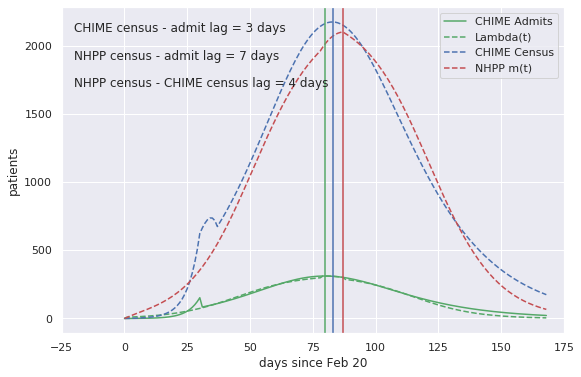

In [97]:
plt.plot(x, y_admits, 'g-', label="CHIME Admits")
plt.plot(x, y_lambda, 'g--', label="Lambda(t)")
plt.plot(x, y_census, 'b--', label="CHIME Census")
plt.plot(x, y_mv, 'r--', label="NHPP m(t)")
plt.xlabel('days since Feb 20')
plt.ylabel('patients')
plt.axvline(admit_peak, color = 'g')
plt.axvline(census_peak, color = 'b')
plt.axvline(mv_peak, color = 'r')
plt.xlim(-25, 175)
plt.text(-20,2100, lag1_txt)
plt.text(-20,1900, lag2_txt)
plt.text(-20,1700, diff_txt)
plt.legend()
plt.show()

Notice how the deterministic lag differs from the lag one gets using the stochastic model. And, the lag with the stochastic model is equal to the ALOS.

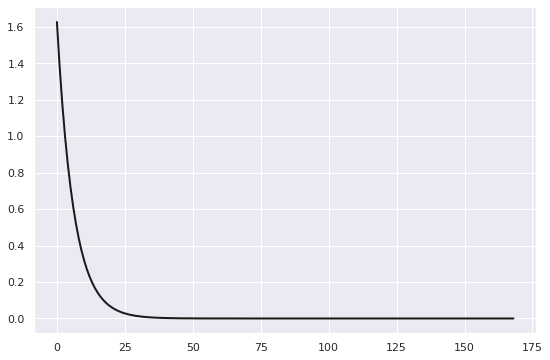

In [145]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, rv1.pdf(x), 'k-', lw=2, label='frozen pdf')

## M(t)/H3/inf model

Now let's pretend there are three simplified patient types.

* Type 1 - just use hospital bed, no icu (and, obviously, no vent)
* Type 2 - just use icu bed but not a vent
* Type 3 - use icu and vent

In [136]:
p1 = 1.0 - pct_hosp_w_icu
p2 = (1.0 - pct_icu_w_vent) * pct_hosp_w_icu
p3 = 1.0 - p1 - p2
(p1, p2, p3)

(0.7, 0.09999999999999998, 0.20000000000000007)

In [139]:
rate1 = 1.0 / hosp_los_star
rate2 = 1.0 / icu_los_star
rate3 = 1.0 / vent_los

### Hyperexponential service times
What does density look like?

In [141]:
rv1 = expon(scale = 1.0 / rate1)
rv2 = expon(scale = 1.0 / rate2)
rv3 = expon(scale = 1.0 / rate3)

In [148]:
def hyperexpon_pdf(x, p1, p2, p3, rate1, rate2, rate3):
    rv1 = expon(scale = 1.0 / rate1)
    rv2 = expon(scale = 1.0 / rate2)
    rv3 = expon(scale = 1.0 / rate3)
    return p1 * rv1.pdf(x) + p2 * rv2.pdf(x) + p3 * rv3.pdf(x)

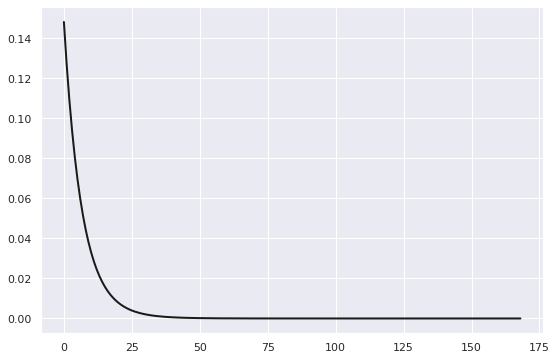

In [149]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, hyperexpon_pdf(x, p1, p2, p3, rate1, rate2, rate3), 'k-', lw=2, label='frozen pdf')

WIP - then this

## Stuff from part 1 of the modeling posts
Below is the census related stuff from part 1. We'll likely need some of this to compare queueing model census projections to CHIME census projections.

### Step 3 - Census
Remember, this is a deterministic model. The user is asked to provide three average length of stay (ALOS) values:

* `hospitalized-day` - average time spent in the hospital by **any covid-19 patient, in any bed type**.
* `icu days` - average time spent in an ICU bed **only for those covid-19 patients who went to an ICU**.
* `ventilated-day` - average time spent on a ventilator **only for those covid-19 patients who were ventilated**

**IMPORTANT** - see the Documentation on user inputs for ALOS at https://code-for-philly.gitbook.io/chime/what-is-chime/parameters#length-of-stay.

### Assumptions and interpretations

There are some other important assumptions and interpretations regarding the interplay between these ALOS values for the different resources.

$$
H \subset C \subset V
$$

Ventilated patients are a subset of ICU patients and ICU patients are a subset of hospitalized patients. This keeps things simpler in the sense that we are estimating average census values for each resource independently by, essentially, multiplying the arrival rate (average number of new dispositions per day) by the appropriate ALOS value (the Python code does this in a different manner but the result is the same). A couple of points:

* for those of you with a bit of queueing or "process physics" knowledge, this is just [Little's Law](https://en.wikipedia.org/wiki/Little%27s_law).
* this model is not in any way looking at details of patient flow patterns such as the fact that patients may take different paths through the hospital:
  - Regular bed --> Discharge
  - Regular bed --> ICU --> Regular/step down --> Discharge
  - Regular bed --> ICU --> Discharge
  - ICU --> Discharge
  - ICU --> Regular/step down --> Discharge
  - Step Down --> Discharge
  - ... etc.
* there is no explicit consideration of capacity limits,
* there is no explicit consideration of parameter uncertainty or stochastic processes.

This is **not** a criticism of the model. All models are approximations, models have varying purposes and there are always tradeoffs. The CHIME model balances complexity, number and availability of user inputs, and its goal of being a quick, rough approximation of resource implications during early to middle stages (i.e. before capacity becomes the limiting factor) of a spreading virus. As capacity becomes more of an issue, there will likely be a need for additional models. Discrete event patient flow simulation models are one of the likely candidates. If interested, you can see simple examples of such models using the Python [simpy](https://simpy.readthedocs.io/en/latest/) package in two blog posts I did, [here](http://hselab.org/simpy-getting-started-patient-flow-modeling.html) and [here](http://hselab.org/simpy-first-oo-patflow-model.html).

### Computing average census values
Census can be computed for each resource independently using the `admits_df` DataFrame and the appropriate ALOS value for the resource. Here's the annotated code.

```python
def build_census_df(
    admits_df: pd.DataFrame,
    lengths_of_stay: Dict[str, int],
) -> pd.DataFrame:
    """Average Length of Stay for each disposition of COVID-19 case (total guesses)"""
    return pd.DataFrame({
        'day': admits_df.day,
        'date': admits_df.date,
        **{
            key: (                       # See below for illustration of this computation
                admits_df[key].cumsum()
                - admits_df[key].cumsum().shift(los).fillna(0)
            )
            for key, los in lengths_of_stay.items()
        }
    })
```

Ok, the key line is

```python
admits_df[key].cumsum()
                - admits_df[key].cumsum().shift(los).fillna(0)
```

Let's see how this works.

In [12]:
# Grab the dataframes we need
admits_df = results['admits_df']
census_df = results['census_df']

# Let's look at hospitalized 
key = 'hospitalized'
los = 7

# Make a mini DataFrame with columns to illustrate the computation
admits = admits_df[key]
census = census_df[key]
cum_admits = admits_df[key].cumsum()
shifted_cum_admits = admits_df[key].cumsum().shift(los).fillna(0)

census_demo_df = pd.DataFrame({
    'admits': admits,
    'cum_admits': cum_admits,
    'shifted_cum_admits': shifted_cum_admits,
    'census_computation': cum_admits - shifted_cum_admits,
    'census_chime': census
})

census_demo_df.head(15)

,admits,cum_admits,shifted_cum_admits,census_computation,census_chime
0,NaN,NaN,0.000000,NaN,NaN
1,0.283108,0.283108,0.000000,0.283108,0.283108
2,0.343034,0.626142,0.000000,0.626142,0.626142
3,0.415643,1.041785,0.000000,1.041785,1.041785
4,0.503619,1.545405,0.000000,1.545405,1.545405
5,0.610214,2.155619,0.000000,2.155619,2.155619
6,0.739366,2.894984,0.000000,2.894984,2.894984
7,0.895847,3.790831,0.000000,3.790831,3.790831
8,1.085437,4.876268,0.283108,4.593160,4.593160
9,1.315137,6.191406,0.626142,5.565264,5.565264


Consider day 9. The ALOS is 7 days. So, which admits contribute to census on day 9? Well it's the admits from day 3-9, inclusive (7 days worth). All that the code is doing is summing up all the admits from day 0-9, the `cumsum`, and then subtracting off those from 0-2, the shifted `cumsum`. Doing this prevents us from having to do "index math".

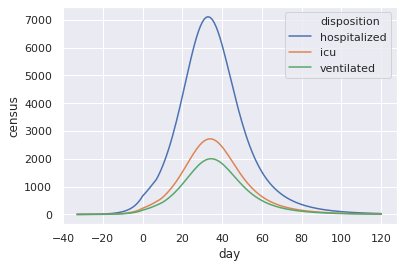

In [47]:
census_df = results['census_df']
census_long = pd.melt(census_df, 
  id_vars=['day', 'date'],
                       value_vars=['hospitalized', 'icu', 'ventilated'],
                       var_name='disposition', value_name='census')


sns.lineplot(x='day', y='census', hue='disposition', 
             data=census_long);

## Sinusoidal arrival rates (not a good fit)

In [60]:
# Compute average arrival rate
lambda_bar = hosp_admits['hospitalized'].mean()
lambda_bar

239.3990216771688

In [109]:
psi_cycle_len_guess = 200
gamma_freq_guess = 2 * math.pi / psi_cycle_len_guess
gamma_freq_guess

0.031415926535897934

In [110]:
# Relative 
alpha_rel_amp_guess = 4

In [111]:
beta_guess = lambda_bar * alpha_rel_amp_guess
beta_guess

957.5960867086752

In [112]:
sin_guess = lambda_bar + beta_guess * np.sin(gamma_freq_guess * hosp_admits.rel_day)
sin_guess

0      239.399022
1      269.477842
2      299.526977
3      329.516774
4      359.417636
          ...    
150   -718.197065
151   -717.724549
152   -716.307468
153   -713.947220
154   -710.646134
Name: rel_day, Length: 155, dtype: float64

In [113]:
x = np.array(hosp_admits.rel_day)
y = np.array(sin_guess)
y_act = hosp_admits['hospitalized']

2020-04-05 10:11:23,960 - matplotlib.legend - WARNING - No handles with labels found to put in legend.


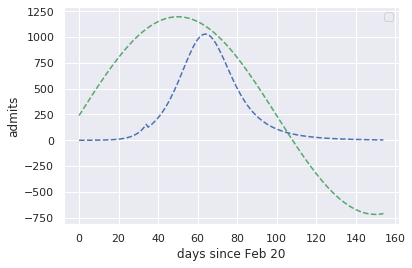

In [114]:
plt.plot(x, y, 'g--')
plt.plot(x, y_act, 'b--')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.show()

In [115]:
# Function to fit
def sin_func(x, a, b, c):
     return a + b * np.sin(c * x)

In [116]:
popt, pcov = curve_fit(sin_func, x, y_act,  p0=(240, 950, 0.03))
print(popt)

[-8.24497333e+01  5.91986511e+02  2.28486209e-02]


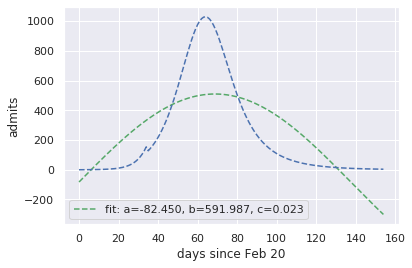

In [117]:
plt.plot(x, func(x, *popt), 'g--',
         label='fit: a={:5.3f}, b={:5.3f}, c={:5.3f}'.format(*popt))
plt.plot(x, y_act, 'b--')
plt.xlabel('days since Feb 20')
plt.ylabel('admits')
plt.legend()
plt.show()

## Exponential service times

Equation (15) in Eick (1993b).

In [ ]:
def m_t_exp(t, lambda_bar, beta, gamma):
    return lambda_bar + ( beta / ( 1 + gamma ** 2)) *(math.sin(gamma * t) - gamma * math.cos(gamma * t))
    

## Concluding remarks
Hopefully this helps clarify how CHIME is currently computing resource use. In the next notebook, I'll build on this and explore the implied arrival rates and ALOS values for subpopulations of patients such as those covid-19 patients who do NOT use ICU and those ICU patients who do NOT use a vent. These are simple algebraic computations and by feeding them back to users, might help people calibrate their inputs better.

<font size="2">This material is made available under the [MIT License](https://opensource.org/licenses/MIT).</font>